In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator
from sklearn.impute import KNNImputer
import plotly.express as px
from plotly.subplots import make_subplots
from fuzzywuzzy import process
import plotly.graph_objects as go
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pointbiserialr

In [112]:
data = pd.read_csv('../data/raw/scraped_apartment_sales_data.csv')

# *1. Initial Clean-up*

In [113]:
df = data.copy()

#### Dropping Columns

In [114]:
df.columns

Index(['Unnamed: 0', 'address', 'location', 'date_sold', 'price_sold_sek',
       'price_listed_sek', 'price_square_meter_sek', 'residence_type',
       'number_of_rooms', 'area_size', 'balcony', 'floor_number', 'elevator',
       'year_built', 'annual_fee_sek', 'annual_cost_sek', 'broker_name',
       'brokerage_firm'],
      dtype='object')

Removing features that won't be used in the model:
- 'Unnamed: 0' is just some kind of index from the csv
- 'residence_type' is apartment for all rows
- 'price_listed_sek', 'date_sold', and 'price_square_meter_sek' would be data leakage in a model
- 'address' has too many unique values to process

In [115]:
df = df.drop([
              'Unnamed: 0', 
              'residence_type', 
              'price_listed_sek', 
              'date_sold', 
              'address', 
              'price_square_meter_sek'
              ], 
              axis=1)

#### Names

In [116]:
df.columns

Index(['location', 'price_sold_sek', 'number_of_rooms', 'area_size', 'balcony',
       'floor_number', 'elevator', 'year_built', 'annual_fee_sek',
       'annual_cost_sek', 'broker_name', 'brokerage_firm'],
      dtype='object')

In [117]:
df = df.rename(columns={'location': 'region', 'balcony': 'has_balcony', 'elevator': 'has_elevator', 'broker_name': 'broker'})
df.columns

Index(['region', 'price_sold_sek', 'number_of_rooms', 'area_size',
       'has_balcony', 'floor_number', 'has_elevator', 'year_built',
       'annual_fee_sek', 'annual_cost_sek', 'broker', 'brokerage_firm'],
      dtype='object')

# *2. Duplicates*

In [118]:
print(df.duplicated().sum())

17


In [119]:
duplicates = df[df.duplicated()]

duplicates.head()

,region,price_sold_sek,number_of_rooms,area_size,has_balcony,floor_number,has_elevator,year_built,annual_fee_sek,annual_cost_sek,broker,brokerage_firm
250,"Haga Norra, Solna kommun",3805000,3.0,66,Ja,3 av 3,True,1949.0,3870,0,Tim Enström,Svenska Mäklarhuset Solna
350,"Vasastan, Stockholms kommun",10700000,4.0,80,Ja,3 av 6,True,1905.0,977,18600,Joakim Andersson,SkandiaMäklarna Stockholm Vasastan
550,Vasastan,6650000,2.0,62,Ja,1 av 4,True,1906.0,2879,14600,Caroline Hanell,SJÖMAN\FRISK
551,Vällingby,2210000,2.0,58,Ja,1 av 3,True,1954.0,3131,0,Emil Johnsson,Notar
600,"Vasastan, Stockholms kommun",15250000,3.0,165,Ja,4 av 5,True,NaN,8209,7200,Tina Engström,Bjurfors Vasastan


In [120]:
df = df.drop_duplicates()

assert df.duplicated().sum() == 0

We also have a lot of similar regions (e.g. 'södermalm' and 'södermalm, stockholms kommun')

In [121]:
# Custom function to unify region names
def unify_region_name(region_name):
    # Split the name and take the first part
    # This removes the part after the comma
    simplified_name = region_name.split(',')[0]
    
    # Further processing if needed
    # For example, removing a common prefix
    if simplified_name.startswith('region'):
        simplified_name = simplified_name.replace('region', '')
    
    return simplified_name

# Apply this function to the region column
df['region'] = df['region'].apply(unify_region_name)

# *3. Strings*

In [122]:
str_cols = df.select_dtypes(['object'])
print(str_cols.columns)

Index(['region', 'has_balcony', 'floor_number', 'broker', 'brokerage_firm'], dtype='object')


In [123]:
# Turn all strings lowercase
for col in df:
  if df[col].dtype == 'object':
    df[col] = df[col].str.lower().str.strip()

df.head()

,region,price_sold_sek,number_of_rooms,area_size,has_balcony,floor_number,has_elevator,year_built,annual_fee_sek,annual_cost_sek,broker,brokerage_firm
0,bagarmossen,4400000,3.0,74,ja,2 av 3,False,1953.0,4899,9000,maria lundberg,svensk fastighetsförmedling farsta-enskede
1,åby,1015000,1.0,25,unknown,4 av 4,True,1961.0,2265,3120,caroline östlund,skandiamäklarna haninge
2,vasastan / hagastaden,7450000,3.0,725,ja,unknown,False,2023.0,4428,0,marianna maatouk,bronze fastighetsförmedling ab
3,hässelby gård,1395000,1.0,40,ja,2 av 3,True,1955.0,3250,4500,martina hultkrantz,mäklarringen vällingby/hässelby
4,södermalm,3150000,1.0,31,ja,1,True,1963.0,1290,6804,sanna treijs,notar


# *4. Missing Data*

In [124]:
df.isnull().sum()

region               0
price_sold_sek       0
number_of_rooms      1
area_size            0
has_balcony          0
floor_number         0
has_elevator         0
year_built         228
annual_fee_sek       0
annual_cost_sek      0
broker               0
brokerage_firm       0
dtype: int64

Features with missing values: 
- number_of_rooms (1)
- year_built (231)

### 4.1 Number of Rooms

In [125]:
# Only 1 missing number_of_rooms, drop it
df = df.dropna(subset=['number_of_rooms'])
df.shape

(2382, 12)

### 4.2 Year Built

In [126]:
df['year_built'].describe()

count    2.155000e+03
mean     3.331836e+05
std      2.541965e+06
min      1.058000e+03
25%      1.939000e+03
50%      1.965000e+03
75%      2.008000e+03
max      2.022202e+07
Name: year_built, dtype: float64

There's something wrong here as we find values with extreme values. We'll evaluate them in the outliers section.

In [127]:
# Identify the percentage of missing values in year_built
pct_missing_year_built = df['year_built'].isnull().sum() / df['year_built'].size
print(f"{pct_missing_year_built*100}%")

# TODO Don't forget to deal with missing data later!

9.529806884970613%


Almost 10% of data has missing values. We'll just drop them for our initial 
baseline model then impute that in some way during the modeling process and see
if it improves performance.

# *5. Outliers*

In the missing values-exploration we found extreme outliers that are obvious 
mistakes as they contain year_built values >2023 and also values unreasonably
low.

In [128]:
less_than_1800 = df[df['year_built'] < 1800]

less_than_1800['year_built'].unique()

array([1058.])

In [129]:
more_than_2023 = df[df['year_built'] > 2023]

more_than_2023['year_built'].unique()

array([1.9711974e+07, 1.9571961e+07, 1.9611962e+07, 2.0122013e+07,
       1.9891990e+07, 2.0162017e+07, 2.0132014e+07, 1.9711972e+07,
       1.9831984e+07, 2.0222023e+07, 1.9801981e+07, 2.0082009e+07,
       2.0142016e+07, 1.9411944e+07, 2.0240000e+03, 1.9861987e+07,
       1.9001910e+07, 1.9731974e+07, 1.9851986e+07, 1.9291930e+07,
       2.0072008e+07, 1.9541955e+07, 2.0202021e+07, 1.9911993e+07,
       1.9791980e+07, 1.9491950e+07, 1.9671969e+07, 1.9871989e+07])

In [130]:
# Drop rows with year_built later than 2023 or earlier than 1800
df = df[(df['year_built'] >= 1800) & (df['year_built'] <= 2023)]

# *6. Processing Categorical Data*

In [131]:
df_categorical = df.select_dtypes(['object'])

df_categorical.columns

Index(['region', 'has_balcony', 'floor_number', 'broker', 'brokerage_firm'], dtype='object')

In [132]:
df_categorical.describe()

,region,has_balcony,floor_number,broker,brokerage_firm
count,2116,2116,2116,2116,2116
unique,495,3,123,952,300
top,södermalm,ja,unknown,sanna treijs,notar
freq,132,1482,224,15,247


### 6.1 Region

In [133]:
top_10_locations = df_categorical['region'].value_counts().head(10)

top_10_locations = df_categorical['region'].value_counts().head(10).index.to_list()

top_10_locations

['södermalm',
 'vasastan',
 'kungsholmen',
 'östermalm',
 'bromma',
 'årsta',
 'hammarby sjöstad',
 'råsunda',
 'centrala sundbyberg',
 'gröndal']

In [134]:
# Mapping function
def map_location(region):
    if region in top_10_locations:
        return region
    else:
        return 'Other'

In [135]:
# Apply the mapping function to the 'location' column
df['region_processed'] = df['region'].apply(map_location)

# One-Hot Encoding
df = pd.get_dummies(df, columns=['region_processed'], drop_first=True)

# Display the first few rows of the processed DataFrame
df.head()

,region,price_sold_sek,number_of_rooms,area_size,has_balcony,floor_number,has_elevator,year_built,annual_fee_sek,annual_cost_sek,...,region_processed_bromma,region_processed_centrala sundbyberg,region_processed_gröndal,region_processed_hammarby sjöstad,region_processed_kungsholmen,region_processed_råsunda,region_processed_södermalm,region_processed_vasastan,region_processed_årsta,region_processed_östermalm
0,bagarmossen,4400000,3.0,74,ja,2 av 3,False,1953.0,4899,9000,...,False,False,False,False,False,False,False,False,False,False
1,åby,1015000,1.0,25,unknown,4 av 4,True,1961.0,2265,3120,...,False,False,False,False,False,False,False,False,False,False
2,vasastan / hagastaden,7450000,3.0,725,ja,unknown,False,2023.0,4428,0,...,False,False,False,False,False,False,False,False,False,False
3,hässelby gård,1395000,1.0,40,ja,2 av 3,True,1955.0,3250,4500,...,False,False,False,False,False,False,False,False,False,False
4,södermalm,3150000,1.0,31,ja,1,True,1963.0,1290,6804,...,False,False,False,False,False,False,True,False,False,False


### 6.2 Balcony

In [136]:
df['has_balcony'].unique()

array(['ja', 'unknown', 'nej'], dtype=object)

In [137]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['has_balcony'], drop_first=True)

# Display the first few rows of the processed DataFrame
df.head()

,region,price_sold_sek,number_of_rooms,area_size,floor_number,has_elevator,year_built,annual_fee_sek,annual_cost_sek,broker,...,region_processed_gröndal,region_processed_hammarby sjöstad,region_processed_kungsholmen,region_processed_råsunda,region_processed_södermalm,region_processed_vasastan,region_processed_årsta,region_processed_östermalm,has_balcony_nej,has_balcony_unknown
0,bagarmossen,4400000,3.0,74,2 av 3,False,1953.0,4899,9000,maria lundberg,...,False,False,False,False,False,False,False,False,False,False
1,åby,1015000,1.0,25,4 av 4,True,1961.0,2265,3120,caroline östlund,...,False,False,False,False,False,False,False,False,False,True
2,vasastan / hagastaden,7450000,3.0,725,unknown,False,2023.0,4428,0,marianna maatouk,...,False,False,False,False,False,False,False,False,False,False
3,hässelby gård,1395000,1.0,40,2 av 3,True,1955.0,3250,4500,martina hultkrantz,...,False,False,False,False,False,False,False,False,False,False
4,södermalm,3150000,1.0,31,1,True,1963.0,1290,6804,sanna treijs,...,False,False,False,False,True,False,False,False,False,False


### 6.3 Floor Number

In [138]:
df['floor_number'].unique()

array(['2 av 3', '4 av 4', 'unknown', '1', '1 av 2', '0', '7 av 9',
       '4 av 5', '1 av 3', '2 av 8', '11', '2 av 2', '3 av 3', '1 av 4',
       '12 av 12', '4 av 6', '6 av 7', '1 av 6', '6 av 10', '3 av 4',
       '5 av 5', '2 av 7', '5', '11 av 11', '1 av 5', '3', '5 av 8',
       '6 av 6', '2 av 6', '5 av 10', '4', '9 av 12', '2', '3 av 5',
       '3 av 6', '7 av 7', '5 av 7', '3 av 8', '1 av 7', '2 av 5', '6',
       '7 av 13', '3 av 9', '7 av 8', '4 av 7', '13 av 14', '3 av 7',
       '1 av 8', '11 av 13', '5 av 6', '2 av 4', '4 av 9', '6 av 8',
       '6 av 9', '3 av 23', '7', '-1 av 7', '12 av 22', '4 av 8',
       '4 av 12', '5 av 17', '2 av 19', '10 av 12', '10', '-1', '6 av 14',
       '0 av 1', '10 av 10', '20 av 21', '9 av 16', '2 av 12', '0 av 5',
       '1 av 1', '8 av 9', '8 av 12', '8 av 10', '6 av 16', '3 av 11',
       '8 av 8', '15 av 15', '8', '2 av 9', '6 av 11', '10 av 11',
       '0 av 7', '9 av 9', '-1 av 2', '-1 av 4', '13 av 16', '0 av 3',
       '3 av 10',

In [139]:
df['floor_number'].value_counts()

floor_number
unknown     224
3 av 3      154
2 av 3      140
1 av 3      128
1            90
           ... 
3 av 23       1
0 av 6        1
13 av 14      1
9 av 16       1
2 av 10       1
Name: count, Length: 123, dtype: int64

In [140]:
# Function to extract and clean floor number
def clean_floor_number(floor_str):
    if pd.isna(floor_str) or floor_str == 'unknown':
        return np.nan
    # Extract the first numeric value
    for part in floor_str.split():
        if part.isdigit() or (part.startswith('-') and part[1:].isdigit()):
            return int(part)
    return np.nan

In [141]:
# Apply the function to the floor_number column
df['cleaned_floor_number'] = df['floor_number'].apply(clean_floor_number)

# Convert the cleaned floor number to a numeric data type
df['cleaned_floor_number'] = pd.to_numeric(df['cleaned_floor_number'])

In [142]:
# Display the first few rows of the DataFrame with the cleaned column
df[['floor_number', 'cleaned_floor_number']].head(10)

,floor_number,cleaned_floor_number
0,2 av 3,2.0
1,4 av 4,4.0
2,unknown,NaN
3,2 av 3,2.0
4,1,1.0
5,1 av 2,1.0
6,0,0.0
7,7 av 9,7.0
8,4 av 5,4.0
10,4 av 4,4.0


In [143]:
df['cleaned_floor_number'].isnull().sum()

224

In [144]:
# TODO Missing values in floor_number 

### 6.4 Broker

In [145]:
df['broker'].value_counts()

broker
sanna treijs          15
nicklas talvitie      14
vilhelm åman          10
johan nilsson          9
jonathan rappel        9
                      ..
georgio hadad          1
aram soma              1
viktor milovanovic     1
danis ayoubi           1
tomas eriksson         1
Name: count, Length: 952, dtype: int64

- High Cardinality: If there are too many unique brokers, it might not be practical to use them directly in models.
- Grouping: You could group less frequent broker names into a 'Other' category.
- One-Hot Encoding: For the remaining frequent categories, use one-hot encoding to convert them into a binary format that can be used in machine learning models.

I feel like there's too low sample sizes per broker. Let's not use this one for now.

### 6.5 Brokerage Firm

- High Cardinality: If there are too many unique brokers, it might not be practical to use them directly in models.
- Grouping: You could group less frequent broker names into a 'Other' category.
- One-Hot Encoding: For the remaining frequent categories, use one-hot encoding to convert them into a binary format that can be used in machine learning models.

In [146]:
df['brokerage_firm'].value_counts().head(10)

brokerage_firm
notar                                               247
erik olsson fastighetsförmedling                    121
länsförsäkringar fastighetsförmedling solna          34
tradition mäkleri                                    32
fastighetsbyrån stockholm - södermalm                31
fastighetsbyrån stockholm - vasastan                 28
historiska hem                                       25
bjurfors kungsholmen                                 23
bjurfors södermalm                                   23
länsförsäkringar fastighetsförmedling sollentuna     23
Name: count, dtype: int64

In [147]:
top_5_brokerage_firms = df['brokerage_firm'].value_counts().head(5).index.to_list()

In [148]:
def map_brokerage_firm(firm):
  if firm in top_5_brokerage_firms:
    return firm
  else:
    return 'Other'

In [149]:
df['brokerage_firm_processed'] = df['brokerage_firm'].apply(map_brokerage_firm)

df['brokerage_firm_processed'].value_counts()

brokerage_firm_processed
Other                                          1651
notar                                           247
erik olsson fastighetsförmedling                121
länsförsäkringar fastighetsförmedling solna      34
tradition mäkleri                                32
fastighetsbyrån stockholm - södermalm            31
Name: count, dtype: int64

In [150]:
df = pd.get_dummies(df, columns=['brokerage_firm_processed'], drop_first=True)

df.head()

,region,price_sold_sek,number_of_rooms,area_size,floor_number,has_elevator,year_built,annual_fee_sek,annual_cost_sek,broker,...,region_processed_årsta,region_processed_östermalm,has_balcony_nej,has_balcony_unknown,cleaned_floor_number,brokerage_firm_processed_erik olsson fastighetsförmedling,brokerage_firm_processed_fastighetsbyrån stockholm - södermalm,brokerage_firm_processed_länsförsäkringar fastighetsförmedling solna,brokerage_firm_processed_notar,brokerage_firm_processed_tradition mäkleri
0,bagarmossen,4400000,3.0,74,2 av 3,False,1953.0,4899,9000,maria lundberg,...,False,False,False,False,2.0,False,False,False,False,False
1,åby,1015000,1.0,25,4 av 4,True,1961.0,2265,3120,caroline östlund,...,False,False,False,True,4.0,False,False,False,False,False
2,vasastan / hagastaden,7450000,3.0,725,unknown,False,2023.0,4428,0,marianna maatouk,...,False,False,False,False,NaN,False,False,False,False,False
3,hässelby gård,1395000,1.0,40,2 av 3,True,1955.0,3250,4500,martina hultkrantz,...,False,False,False,False,2.0,False,False,False,False,False
4,södermalm,3150000,1.0,31,1,True,1963.0,1290,6804,sanna treijs,...,False,False,False,False,1.0,False,False,False,True,False


# *7. Analyze*

In [151]:
df.columns

Index(['region', 'price_sold_sek', 'number_of_rooms', 'area_size',
       'floor_number', 'has_elevator', 'year_built', 'annual_fee_sek',
       'annual_cost_sek', 'broker', 'brokerage_firm',
       'region_processed_bromma', 'region_processed_centrala sundbyberg',
       'region_processed_gröndal', 'region_processed_hammarby sjöstad',
       'region_processed_kungsholmen', 'region_processed_råsunda',
       'region_processed_södermalm', 'region_processed_vasastan',
       'region_processed_årsta', 'region_processed_östermalm',
       'has_balcony_nej', 'has_balcony_unknown', 'cleaned_floor_number',
       'brokerage_firm_processed_erik olsson fastighetsförmedling',
       'brokerage_firm_processed_fastighetsbyrån stockholm - södermalm',
       'brokerage_firm_processed_länsförsäkringar fastighetsförmedling solna',
       'brokerage_firm_processed_notar',
       'brokerage_firm_processed_tradition mäkleri'],
      dtype='object')

In [152]:
# Drop rows with missing values
df_cleaned = df.dropna(how='any', axis=0)

# Directly create X by dropping unnecessary columns
# This step combines both the creation of df_no_missing_data and X from your code
X = df_cleaned.drop(['price_sold_sek', 'broker', 'brokerage_firm', 'region', 'floor_number'], axis=1)

y = df_cleaned['price_sold_sek']

# Directly assign the 'price_sold_sek' column to X, no need for a separate join operation
df_baseline = X.join(y)


In [153]:
df_baseline

,number_of_rooms,area_size,has_elevator,year_built,annual_fee_sek,annual_cost_sek,region_processed_bromma,region_processed_centrala sundbyberg,region_processed_gröndal,region_processed_hammarby sjöstad,...,region_processed_östermalm,has_balcony_nej,has_balcony_unknown,cleaned_floor_number,brokerage_firm_processed_erik olsson fastighetsförmedling,brokerage_firm_processed_fastighetsbyrån stockholm - södermalm,brokerage_firm_processed_länsförsäkringar fastighetsförmedling solna,brokerage_firm_processed_notar,brokerage_firm_processed_tradition mäkleri,price_sold_sek
0,3.0,74,False,1953.0,4899,9000,False,False,False,False,...,False,False,False,2.0,False,False,False,False,False,4400000
1,1.0,25,True,1961.0,2265,3120,False,False,False,False,...,False,False,True,4.0,False,False,False,False,False,1015000
3,1.0,40,True,1955.0,3250,4500,False,False,False,False,...,False,False,False,2.0,False,False,False,False,False,1395000
4,1.0,31,True,1963.0,1290,6804,False,False,False,False,...,False,False,False,1.0,False,False,False,True,False,3150000
5,1.0,40,True,1972.0,2947,4200,False,False,False,False,...,False,False,False,1.0,False,False,False,False,False,1750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2.0,63,True,2021.0,3840,5652,False,False,False,False,...,False,False,False,6.0,False,False,False,False,False,4300000
2394,3.0,77,True,2016.0,4240,3600,False,False,False,False,...,False,False,False,3.0,False,False,False,False,False,2580000
2396,2.0,56,True,1962.0,2446,6100,False,False,False,False,...,False,False,False,3.0,False,False,False,False,False,3150000
2398,2.0,64,False,1908.0,1739,0,False,False,False,False,...,True,False,False,2.0,False,False,False,False,False,8400000


### 7.1 Multicollinearity

In [154]:
def detect_multicolinearity(df: pd.DataFrame, regressors: list[str]):
    """
    Detect multicolinearity among regressors using the VIF methdod. 
        - 1 — features are not correlated
        - 1 < VIF < 5 — features are moderately correlated
        - VIF > 5 — features are highly correlated
        - VIF > 10 — high correlation between features and is cause for concern
    
    Parameters:
        df: DataFrame containing the dataset you want to test
        regressors: list of regressors that you want yo check (must be in dataset)

    Output: 
        DataFrame containing VIF values and tolerance
    """
    vif, tolerance = {}, {} 

    for regressor in regressors:
        X = [f for f in regressors if f != regressor]        
        X, y = df[X], df[regressor]
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        tolerance[regressor] = 1 - r2
        vif[regressor] = 1/(tolerance[regressor])

    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [155]:
detect_multicolinearity(df_baseline, X)

,VIF,Tolerance
number_of_rooms,2.404733,0.415847
area_size,1.080832,0.925213
has_elevator,1.167142,0.856794
year_built,1.491745,0.670356
annual_fee_sek,2.599837,0.384639
annual_cost_sek,1.129772,0.885134
region_processed_bromma,1.039391,0.962102
region_processed_centrala sundbyberg,1.017462,0.982838
region_processed_gröndal,1.027443,0.973290
region_processed_hammarby sjöstad,1.036327,0.964946


In [156]:
corr_matrix = df_baseline.corr()

<Axes: >

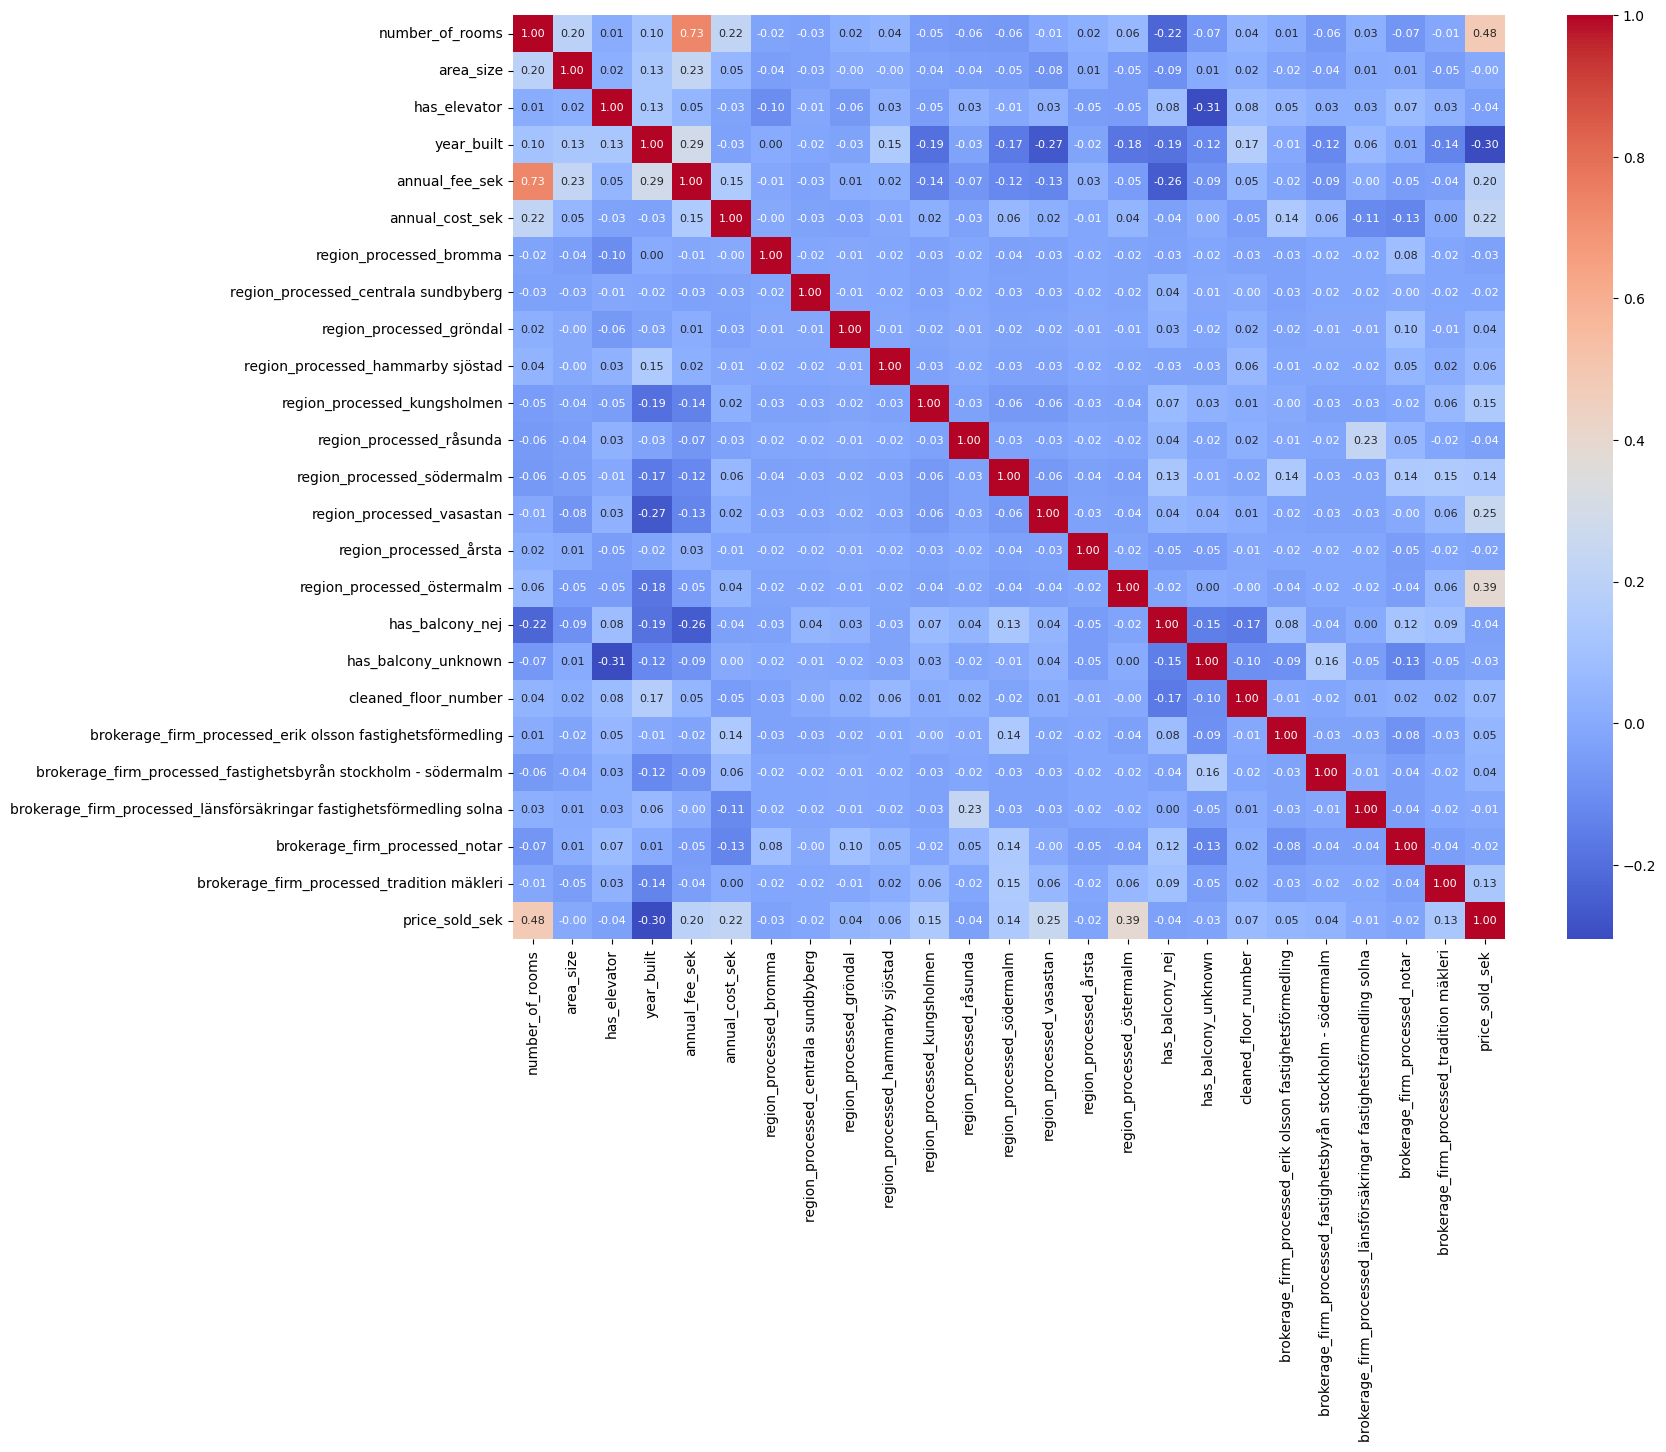

In [157]:
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})

In [158]:
# TODO make plotly corr heatmap!

### 7.2 Relationships to Dependent Variable

<Figure size 1400x1000 with 0 Axes>

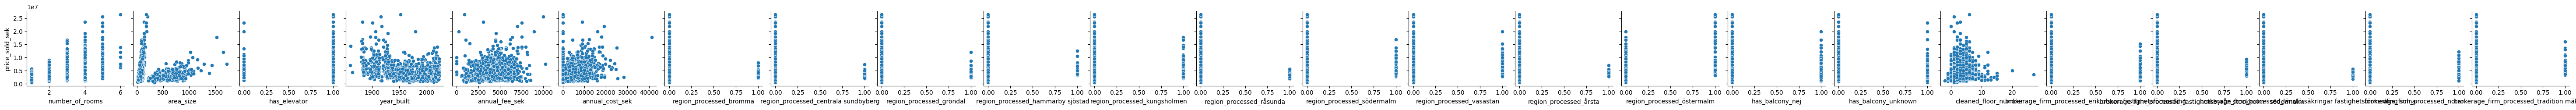

<Figure size 1400x1000 with 0 Axes>

In [159]:
sns.pairplot(df_baseline, y_vars=['price_sold_sek'], x_vars=X.columns)
plt.figure(figsize=(14,10))

In [160]:
"""df_cols = X.columns  # Use the columns from DataFrame 'X'

# Create a subplot figure with a number of rows equal to the number of columns
fig = make_subplots(rows=len(df_cols), cols=1)

# Add a scatter plot for each column in 'X' with 'y' as the y-axis
for i, col in enumerate(df_cols):
    fig.add_trace(go.Scatter(x=X[col], y=y, mode='markers', name=col), row=i + 1, col=1)

# Update layout for each subplot
for i, col in enumerate(df_cols):
    fig.update_yaxes(title_text=col, row=i+1, col=1)

# Update the overall layout
fig.update_layout(
    title_text="Relationship between Independent Variables and Dependent Variable",
    height=300 * len(df_cols),  # Adjust height based on the number of subplots
    showlegend=False  # Optionally hide the legend if it's not needed
)

# Show the figure
fig.show()
"""

'df_cols = X.columns  # Use the columns from DataFrame \'X\'\n\n# Create a subplot figure with a number of rows equal to the number of columns\nfig = make_subplots(rows=len(df_cols), cols=1)\n\n# Add a scatter plot for each column in \'X\' with \'y\' as the y-axis\nfor i, col in enumerate(df_cols):\n    fig.add_trace(go.Scatter(x=X[col], y=y, mode=\'markers\', name=col), row=i + 1, col=1)\n\n# Update layout for each subplot\nfor i, col in enumerate(df_cols):\n    fig.update_yaxes(title_text=col, row=i+1, col=1)\n\n# Update the overall layout\nfig.update_layout(\n    title_text="Relationship between Independent Variables and Dependent Variable",\n    height=300 * len(df_cols),  # Adjust height based on the number of subplots\n    showlegend=False  # Optionally hide the legend if it\'s not needed\n)\n\n# Show the figure\nfig.show()\n'

There are a lot of non-linear relationships which will make a linear model 
problematic unless data is transformed in some way to account for this.

We already checked the correlations between the continuous variables and the 
dependent variable in the previous correlation matrix. Let's check the 
relationships between the one-hot encoded variables and the dependent variable.

In [161]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1892 entries, 0 to 2399
Data columns (total 24 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   number_of_rooms                                                       1892 non-null   float64
 1   area_size                                                             1892 non-null   int64  
 2   has_elevator                                                          1892 non-null   bool   
 3   year_built                                                            1892 non-null   float64
 4   annual_fee_sek                                                        1892 non-null   int64  
 5   annual_cost_sek                                                       1892 non-null   int64  
 6   region_processed_bromma                                               1892 non-null   bool   
 7   re

In [162]:
# Select only the binary (one-hot encoded) variables from X
binary_vars = X.select_dtypes(['bool'])

# Calculate the point-biserial correlation for each binary variable
correlations = {}
for var in binary_vars:
    correlation, p_value = pointbiserialr(binary_vars[var], y)
    correlations[var] = (correlation, p_value)

# Display the results
for var, (corr, pval) in correlations.items():
    if pval < 0.05:
      print(f"{var}: Correlation = {corr}, P-value = {pval}")


region_processed_hammarby sjöstad: Correlation = 0.06379722530217766, P-value = 0.005503387542644128
region_processed_kungsholmen: Correlation = 0.14508214271141406, P-value = 2.2968008660372773e-10
region_processed_södermalm: Correlation = 0.14037757097187803, P-value = 8.65776167911872e-10
region_processed_vasastan: Correlation = 0.2479106080594175, P-value = 6.822557630520113e-28
region_processed_östermalm: Correlation = 0.38559444744068583, P-value = 4.096971894280957e-68
brokerage_firm_processed_erik olsson fastighetsförmedling: Correlation = 0.04921780907887381, P-value = 0.03229696201600288
brokerage_firm_processed_tradition mäkleri: Correlation = 0.13251748092848165, P-value = 7.214491183802043e-09


# *8. Saving Processed Data*

In [163]:
df_baseline.columns

Index(['number_of_rooms', 'area_size', 'has_elevator', 'year_built',
       'annual_fee_sek', 'annual_cost_sek', 'region_processed_bromma',
       'region_processed_centrala sundbyberg', 'region_processed_gröndal',
       'region_processed_hammarby sjöstad', 'region_processed_kungsholmen',
       'region_processed_råsunda', 'region_processed_södermalm',
       'region_processed_vasastan', 'region_processed_årsta',
       'region_processed_östermalm', 'has_balcony_nej', 'has_balcony_unknown',
       'cleaned_floor_number',
       'brokerage_firm_processed_erik olsson fastighetsförmedling',
       'brokerage_firm_processed_fastighetsbyrån stockholm - södermalm',
       'brokerage_firm_processed_länsförsäkringar fastighetsförmedling solna',
       'brokerage_firm_processed_notar',
       'brokerage_firm_processed_tradition mäkleri', 'price_sold_sek'],
      dtype='object')

In [164]:
df_baseline.to_csv('../data/processed/scraped_apartment_sales_baseline.csv')
df.to_csv('../data/processed/scraped_apartment_sales_processed.csv')